# Example Notebook for Tektronix Keithley 2450 source meter

In this example we will setup a number of [four-wire measurements](https://en.wikipedia.org/wiki/Four-terminal_sensing) with the 2540 source meter. We attach a variable resistor to the front terminals and determine if we can measure the correct resistance.

In [1]:
import qcodes as qc 
from qcodes.instrument_drivers.tektronix.Keithley_2450 import Keithley2450
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

In [2]:
keithley = Keithley2450("keithley", "GPIB0::18::INSTR")

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04397524, firmware:1.6.7c) in 0.49s


## Single point measurements 

Attach a variable resistor to the front and source a current 

In [3]:
keithley.terminals("front")
keithley.source.function("current")
keithley.source.current(1E-6)  # Put 1uA through the resistor 
current_setpoint = keithley.source.current()

voltage = keithley.sense.function("voltage")
keithley.output(True)
voltage = keithley.sense.voltage()
keithley.output(False)

print(f"Approx. resistance: ",  voltage/current_setpoint)

Approx. resistance:  1013.1610000000001


We can also directly measure the resistance

In [4]:
voltage = keithley.sense.function("resistance")
keithley.output(True)
resistance = keithley.sense.resistance()
keithley.output(False)

print(f"Measured resistance: ",  resistance)

Measured resistance:  996.0581


In 'current' mode, we cannot set/get a voltage and vice versa

In [5]:
try: 
    keithley.source.voltage()
except AttributeError as err: 
    function = keithley.source.function()
    print(f"In the '{function}' source mode the source module does not have a 'voltage' attribute")

In the 'current' source mode the source module does not have a 'voltage' attribute


This goes for both the source and sense subsystems 

In [6]:
try: 
    keithley.sense.current()
except AttributeError as err:
    function = keithley.sense.function()
    print(f"In the '{function}' sense mode the sense module does not have a 'current' attribute")

In the 'resistance' sense mode the sense module does not have a 'current' attribute


We also need to make sure the output is enabled for use the measure (or 'sense') a current or voltage 

## Sweeping measurements 

The instrument has a build-in sweep system. For the first measurement, we drive a current through the resistor and measure the voltage accross it. 

In [7]:
initialise_database()
experiment = new_experiment(name='Keithley_2450_example', sample_name="no sample")

Sweep the current from 0 to 1uA in 10 steps and measure voltage

In [8]:
keithley.sense.function("voltage")
keithley.sense.auto_range(True)

keithley.source.function("current")
keithley.source.auto_range(True)
keithley.source.limit(2)
keithley.source.sweep_setup(0, 1E-6, 10)

keithley.sense.four_wire_measurement(True)

Starting experimental run with id: 42


([<matplotlib.axes._subplots.AxesSubplot at 0x1c259436128>], [None])

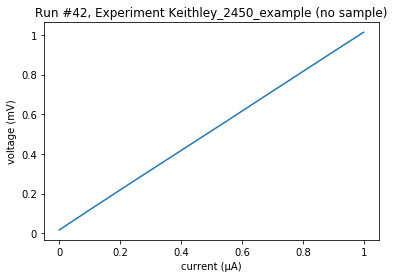

In [9]:
meas = Measurement(exp=experiment)
meas.register_parameter(keithley.sense.sweep)

with meas.run() as datasaver:
    datasaver.add_result((keithley.source.sweep_axis, keithley.source.sweep_axis()),
                         (keithley.sense.sweep, keithley.sense.sweep()))

    dataid = datasaver.run_id

plot_by_id(dataid)

Sweep the voltage from 10mV in 10 steps and measure current 

In [10]:
keithley.sense.function("current")
keithley.sense.range(1E-5)
keithley.sense.four_wire_measurement(True)

keithley.source.function("voltage")
keithley.source.range(0.2)
keithley.source.sweep_setup(0, 0.01, 10)

Starting experimental run with id: 43


([<matplotlib.axes._subplots.AxesSubplot at 0x1c25b5018d0>], [None])

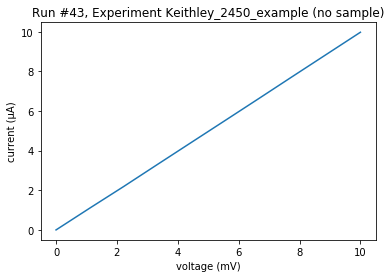

In [11]:
meas = Measurement(exp=experiment)
meas.register_parameter(keithley.sense.sweep)

with meas.run() as datasaver:
    datasaver.add_result((keithley.source.sweep_axis, keithley.source.sweep_axis()),
                         (keithley.sense.sweep, keithley.sense.sweep()))

    dataid = datasaver.run_id

plot_by_id(dataid)